# TP 05 : Régularisation et sélection d'attributs

Binômes :
- Ould Taleb Nada
- Laribi Hakima 

## I. Implémentation

Dans cette partie, on va implémenter deux fonctions de régularisation et deux fonctions de filtrage. 
La régularisation sera appliquée sur la régression logistique binaire dont le code est fourni ici.


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline


# Le code de la réression logistique 

# Somme pondérée des caractéristiques
def zf(X, theta):
    return np.dot(X, theta)

# Transformation d'une valeur à une probabilité
def sg(Z):
    return  1 / (1 + np.exp(-Z))

def hf(X, theta):
    return sg(zf(X, theta))

# Fonction objective
# utilisation d'un petit nombre pour éviter log(0)
def BCE(Y, H, e=1e-8): 
    return - np.mean(Y * np.log(H) + (1-Y) * np.log(1-H))  

# Fonction des gradients
def dBCE(X, Y, H):
    return  np.dot(X.T, H-Y)/X.shape[0]

# Fonction de mise à jour des paramètres
def majTheta(Theta, Gradient, alpha): 
    return Theta - alpha * Gradient


### I.1.  Régularisation (Ridge)


#### I.2.1. Fonction du coût de la régularisation L2

La fonction du coût utilisée de la régularisation **L2** est donnée somme : 

$$J_{L2}(\theta) = \frac{\lambda }{2M} \sum\limits_{j=1}^{N} \theta_j^2$$

- **M** : nombre des échantiollons (observations)
- **N** : nombre des caractéristiques


**Remarque** Dans les énoncés, la régularisation n'est pas divisée par le nombre des échantillons $M$. Mais, en pratique, on la divise. [Voici des réponses sur stackexchange](https://stats.stackexchange.com/questions/287920/regularisation-why-multiply-by-1-2m) expliquant pourquoi.

In [2]:
# TODO Réaliser la fonction du coût de la régularisation L2
def J_L2(Theta, M, Lambda=0.):
    T=Theta ** 2
    Tl=list(T)
    return ((Lambda/(2*M)) * (np.sum(Tl) - Tl[0]))


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.0, 0.0005050000000000001)
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais


J_L2(Theta_t, 4), J_L2(Theta_t, 4, Lambda=.4)

(0.0, 0.0005049999999999999)

#### 1.2.2. Gradients de la régularisation L2

La fonction des gradientsde la régularisation **L2** est définie comme suit :
 
$$\frac{\partial J_{L2}(\theta)}{\partial \theta_j} = \frac{\lambda }{M} \theta_j \text{ si } j > 0$$

$$\frac{\partial J_{L2}(\theta)}{\partial \theta_0} = 0$$

- **X** : matrice (échantillons X caractéristiques)
- **Y** : vecteur des sorties réelles (échantillons)
- **H** : vecteur des estimations (échantillons)
- **M** : nombre des échantillons


In [3]:
# TODO Réaliser la fonction du gradient de la régularisation L2
def dJ_L2(Theta, M, Lambda=0.):
    L=np.zeros(len(Theta))
    for j in range (len(Theta)) :
        if (j!=0) :
            L[j]=(Lambda/M) * Theta[j]
    return L


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais

dJ_L2(Theta_t, 4), dJ_L2(Theta_t, 4, Lambda=0.4)

(array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))

### I.2.  Régularisation (Lasso)

#### I.2.1. Fonction du coût de la régularisation L1

La fonction du coût de la régularisation **L1** sur cette fonction, on aura : 

$$J_{L1}(\theta) = \frac{\lambda}{M} \sum\limits_{j=1}^{N} |\theta_j|$$

- **M** : nombre des échantiollons (observations)
- **N** : nombre des caractéristiques

In [4]:
# TODO Réaliser la fonction du coût de la régularisation L1
def J_L1(Theta, M, Lambda=0.):
    return ((Lambda/M) * (np.sum(np.abs(Theta)) - np.abs(Theta[0])))

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.0, 0.011000000000000001)
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais

J_L1(Theta_t, 4), J_L1(Theta_t, 4, Lambda=.4)

(0.0, 0.01100000000000001)

#### I.2.2. Mise à jour des paramètres 

Le dérivé de $L1$ est :
$$\frac{\partial L1}{\partial \theta_j} = \frac{\partial \frac{\lambda }{M} \sum\limits_{j=1}^{N} |\theta_j|}{\partial \theta_j} = \frac{\lambda }{M} \frac{\theta_j}{|\theta_j|}$$

Il est clair que le gradient n'est pas définit dans le cas $\theta_j = 0$. 
En appliquant [le sous-différentiel](https://fr.wikipedia.org/wiki/Sous-diff%C3%A9rentiel), on aura : 
$$
\frac{\partial L1}{\partial \theta_j} = 
\begin{cases}
-\frac{\lambda}{M} & \text{si } \theta_j < 0 \\
0 & \text{si } \theta_j = 0 \\
\frac{\lambda}{M} & \text{si } \theta_j > 0 \\
\end{cases}
$$

On ne peut pas utiliser la descente du gradient pour résoudre ça. 
On va utiliser un alorithme de descente du gradient approximative, qui s'appelle **Iterative soft-thresholding algorithm (ISTA)**. 
$$prox(\theta) = S_{\lambda}(\theta) = 
\begin{cases}
\theta_j + \lambda & \text{si } \theta_j < - \lambda \\
0 & \text{si } -\lambda \le \theta_j \le \lambda \\
\theta_j - \lambda & \text{si } \theta_j > \lambda \\
\end{cases}
$$

**Vous devez implémenter cette fonction**

Les thétas sont mises à jour comme suite : 
$$ \theta = S_{\lambda}(\theta - \frac{\partial J_0}{\partial \theta})$$
Où, $J_0$ est la fonction du coût sans régularisation

Source : [Ryan Tibshirani (2015), Lecture 08: Proximal Gradient Descent](https://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)

In [5]:
# TODO Réaliser la fonction soft-thresholding : prox(theta)
def S(Theta, Lambda): 
    S=np.zeros(len(Theta))
    for j in range(len(Theta)) :
        if (j==0) :
            S[j]=Theta[j]
        elif (Theta[j]<(-Lambda)):
            S[j]=Theta[j]+Lambda
        elif (Lambda<Theta[j]) :
            S[j]=Theta[j]-Lambda
    return S

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : array([ 0.5 , -0.15,  0.  ])
#---------------------------------------------------------------------

                     
Theta_t = np.array([0.5, -0.25, 0.05])

S(Theta_t, 0.1)

array([ 0.5 , -0.15,  0.  ])

### I.3. Régression avec réglularisation

**Rien à programmer ici**


In [6]:
def descente(X, Y, Theta, approx=False, it_max=100, alpha=0.1, Lambda=0.): 

    M = len(Y)
    
    if approx :
        def maj(Theta, J, dJ):
            J += J_L1(Theta, M, Lambda=Lambda)
            Theta = majTheta(Theta, dJ, alpha)
            Theta = S(Theta, Lambda/M) # Lamdba doit être divisé sur le nombre des échantillons (nous on a enlever le M)
            return J, Theta
    else:
        def maj(Theta, J, dJ):
            J += J_L2(Theta, M, Lambda=Lambda)
            dJ += dJ_L2(Theta, M, Lambda=Lambda)
            Theta = majTheta(Theta, dJ, alpha)
            return J, Theta
            
    couts = []
    Thetas = []
    
    #pour ne pas modifier le contenu de Theta en entrée
    Theta = Theta.copy()
    
    # ici, on boucle jusqu'à arriver aux maximum des itérations
    for it in range(it_max):
        H = hf(X, Theta)
        J = BCE(Y, H)
        dJ = dBCE(X, Y, H)
        J, Theta = maj(Theta, J, dJ)
        couts.append(J)
        Thetas.append(Theta.copy())
    
    return Thetas, couts

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([ 0.94839532, -0.56840255,  1.2813832 ]),
#  array([0.07440919, 0.        , 0.        ]),
#  array([ 0.93431089, -0.53451115,  1.03711393]))
#
#---------------------------------------------------------------------

X_t = np.array([
    [1, 1, 0.2],
    [1, 2, 0.1],
    [1, 3, 0.4],
    [1, 4, 0.3]
])

Theta_t = np.array([1., 1., 1.])

Y_t = np.array([1, 0, 1, 0])

# pas de régularisation : Lambda = 0
Theta_P, J_P = descente(X_t, Y_t, Theta_t)
# régularisation L1 : approximation avec lambda
Theta_1, J_1 = descente(X_t, Y_t, Theta_t, approx=True, Lambda=0.1)
# régularisation L2 : lambda sans approximation
Theta_2, J_2 = descente(X_t, Y_t, Theta_t, Lambda=0.1)

Theta_P[-1], Theta_1[-1], Theta_2[-1]


(array([ 0.94839532, -0.56840255,  1.2813832 ]),
 array([ 0.46328109, -0.15750488,  0.        ]),
 array([ 0.93431089, -0.53451115,  1.03711393]))

In [7]:
import outils

class RegLogReg(object): # Régression logistique régularisée
    
    # par défaut : pas de régularisation
    def __init__(self, nbr_iter=100, alpha=.01, Lambda=1.0, norm=True, const=True, reg=None): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.norm = norm
        self.const = const
        self.approx = None
        self.Lambda = Lambda
        if reg == "l1":
            self.approx = S
        elif reg != "l2":
            self.Lambda = 0.
    
    def entrainer(self, X, Y): 
        X_pre, self.mean, self.std = outils.preparer(X, norm=self.norm, const=self.const)
        Theta = outils.generer_uns_1(X_pre.shape[1])#
        self.Thetas, self.couts = descente(X_pre, Y, Theta, 
                                          approx=self.approx, 
                                          it_max=self.nbr_iter, 
                                          alpha=self.alpha, 
                                          Lambda=self.Lambda)
        
    # La prédiction
    # si classes=True elle rend une vecteur de 1 et 0
    # sinon elle rend un vecteur de probabilités
    def predire(self, X, classes=True, seuil=0.5, it=-1):
        X_pre, self.mean, self.std = outils.preparer(X, norm=self.norm, const=self.const, mean=self.mean, std=self.std)
        H = hf(X_pre, self.Thetas[it])
        if classes:
            return (H >= seuil).astype(int)
        return H

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([0.86383643, 0.5273866 , 0.96123235]),
#  array([0.79153709, 0.        , 0.        ]),
#  array([0.8515839 , 0.38351525, 0.7672672 ]),
#  array([0, 0, 1, 1]))
#---------------------------------------------------------------------

X_t = np.array([
    [100, 20],
    [200, 10],
    [300, 40],
    [400, 30]
])

Y_t = np.array([1, 0, 1, 0])

# pas de régularisation
reglog = RegLogReg()
reglog.entrainer(X_t, Y_t)
# régularisation L1
reglog1 = RegLogReg(reg="l1")
reglog1.entrainer(X_t, Y_t)
# régularisation L2
reglog2 = RegLogReg(reg="l2")
reglog2.entrainer(X_t, Y_t)

reglog.Thetas[-1], reglog1.Thetas[-1], reglog2.Thetas[-1], reglog.predire(X_t)

(array([0.86383643, 0.5273866 , 0.96123235]),
 array([0.79241836, 0.        , 0.        ]),
 array([0.8515839 , 0.38351525, 0.7672672 ]),
 array([0, 0, 1, 1]))

### I.4. Filtrage des attributs (ANOVA : Analysis of Variance)

Le nombre des échantillons pour chaque classe est différent. 
Pour cette raison, on va implémenter ANOVA for a CRD (COMPLETELY RANDOM DESIGN). 
On va implémenter l'algorithme expliqué dans [Richard Horsly (2012) COMPLETELY RANDOM DESIGN (CRD)](https://www.ndsu.edu/faculty/horsley/CRD.pdf). 
Pour valider l'implémentation, on va utiliser les mêmes données de la page 10.

#### I.4.1. One way F value pour un seul attribue

pour un attribut donné ($A$), on divise l'ensemble de ses échantillons sur $N$ ensembles, où $N$ est le nombre des classes. 

$$CF = \frac{(\sum_{ij} A_{ij})^2}{\sum_j |A_j|} $$
Où $\sum_{ij} A_{ij}$ est la somme de toutes les valeurs de toutes les classes, 
$\sum_j |A_j|$ est le nombre total des échantillons (de toutes les classes)

$$ TotalSS = \sum_{ij} A_{ij}^2 - CF$$
Où $\sum_{ij} A_{ij}^2$ est les somme des carrées de toutes les valeurs

$$ TreatmentSS = \sum_j \frac{(\sum_{i} A_{ij})^2}{|A_j|} - CF$$
Où $\sum_{i} A_{ij}$ est la somme des valeurs de la classe $j$ et $|A_j|$ est le nombre des éléments dans la classe $j$

$$ ErrorSS = TotalSS - TreatmentSS $$


In [8]:
# TODO Compléter la fonction one-way ANOVA pour un attribut
def f_oneway(A): 
    # A est une liste de N listes où N est le nombre des classes
    # Ces listes n'ont pas la même taille
    nbrs = np.array([len(a) for a in A]) # nombre des échantillons de chaque classe
    sommes = np.array([np.sum(a) for a in A]) # somme des valeurs de chaque classe
    sommes_caree = np.sum([np.sum(np.array(a)**2) for a in A]) # somme des valeurs carrées de toutes les valeurs
    
    # Compléter ici
    #====================================
    CF = ((np.sum(sommes))**2)/np.sum(nbrs)
    TotalSS = sommes_caree - CF
    TreatmentSS = np.sum([((sommes[i])**2/nbrs[i]) for i in range(len(nbrs))]) - CF
    ErrorSS = TotalSS - TreatmentSS
    #====================================
    
    MSB = TreatmentSS / (len(A) - 1) 
    MSW =  ErrorSS/(nbrs.sum() - len(A))
    return MSB/MSW


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 6.418894830659841
#---------------------------------------------------------------------

AA = [[2., 2.2, 1.8, 2.3, 1.7], [1.7, 1.9, 1.5], [2., 2.4, 2.7, 2.5, 2.4], [2.1, 2.2, 2.2, 1.9]]
# Résultat : 6.418894830659841 (voir page 11 step 6)
f_oneway(AA)

6.418894830659841

#### I.4.2. One way F value pour tous les attribues

**Rien à programmer ou analyser ici**

Ici, on va calculer ANOVA pour chaque attribut. 
Les attributs avec des grandes valeurs ANOVA sont meilleurs. 



In [9]:
def anova_f(X, Y): 
    
    C = np.unique(Y)
    F = []
    for j in range(X.shape[1]): 
        A = X[:, j]
        F.append(f_oneway([A[Y==c] for c in np.unique(Y)]))
    return np.array(F)


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([  6.41889483,   0.40595497, 105.2745098 ]),
#  array([  6.41889483,   0.40595497, 105.2745098 ]))
#---------------------------------------------------------------------

X_t = np.array(
    [[2. , 1. , 1. ],
     [2.2, 2. , 1. ],
     [1.8, 3. , 1. ],
     [2.3, 4. , 1. ],
     [1.7, 5. , 2. ],
     [1.7, 1. , 2. ],
     [1.9, 2. , 2. ],
     [1.5, 3. , 2. ],
     [2. , 1. , 3. ],
     [2.4, 2. , 3. ],
     [2.7, 3. , 3. ],
     [2.5, 4. , 3. ],
     [2.4, 5. , 3. ],
     [2.1, 1. , 4. ],
     [2.2, 2. , 4. ],
     [2.2, 3. , 4. ],
     [1.9, 4. , 4. ]])

Y_t = np.array(["A", "A", "A", "A", "A", "B", "B", "B", "C", "C", "C", "C", "C", "D", "D", "D", "D"])

# pour valider, on va utiliser f_classif de scikit-learn 
# https://github.com/scikit-learn/scikit-learn/blob/95d4f0841d57e8b5f6b2a570312e9d832e69debc/sklearn/feature_selection/_univariate_selection.py#L42
from sklearn.feature_selection import f_classif
f_sklearn, a = f_classif(X_t, Y_t)
# la première liste est celle de scikit-learn et la deuxième est la notre
f_notre = anova_f(X_t, Y_t)

f_sklearn, f_notre

(array([  6.41889483,   0.40595497, 105.2745098 ]),
 array([  6.41889483,   0.40595497, 105.2745098 ]))

## II. Application et analyse

On va utiliser le dataset [Diabetics prediction using logistic regression](https://www.kaggle.com/kandij/diabetes-dataset). 

In [10]:
diabetes = pd.read_csv("datasets/diabetes2.csv") 
X_diabetes = diabetes.iloc[:, :-1].values  
Y_diabetes = diabetes.iloc[:, -1].values

# Cette configuration est mise en place comme ceci exprès
# C'est pour tester le cas où la régression est difavorisée
NBR_TEST = 240
# Supposant que les 30% premières lignes sont pour le test et le reste pour l'entraînement
X_test = X_diabetes[-NBR_TEST:, :] # 30% ou plus
Y_test = Y_diabetes[-NBR_TEST:]

X_train = X_diabetes[:-NBR_TEST, :] 
Y_train = Y_diabetes[:-NBR_TEST]

diabetes.head()
print(diabetes)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

### II.1. Régularisation

Nous avons entrainé 3 modèles :
- **reglog** : régression logistique sans régularisation
- **reglog_l1** : régression logistique avec régularisation L1
- **reglog_l2** : régression logistique avec régularisation L2

Nous avons testé ces modèles en utilisant deux datasets (avec la métrique F1 dans chaque itération) :
- **entrainement** : pour tester la convergence (fitting)
- **test** : pour tester la généralisation

Afin de capturer les F1 scores et les paramètres, nous avons entrainé chaque modèle avec une seule itération et utiliser une boucle globale pour contrôler les traitements de chaque itération. Pour continuer l'entrainement à partir des thétas précédents, nous avons activé l'option **warm_start**. Ceci va générer des graphiques non lisses (puisqu'on lance l'algorithme d'optimisation à chaque itération).

#### II.1.1.  Convergence et généralisation sans et avec régularisation par itérations

Ici, on suppose que l'algorithme a convergé lorsqu'il atteint le maximum de F1 score dans l'antrainement (normalement, il doit sortir s'il y a une chutte de F1 score et retourne les thétats les plus optimaux). Donc, au delà du point de la convergence, nous avons continuer l'itération pour voir ce qui va se passer. 


**Analyser les résultats**

- Que remarquez-vous ?
- Analyser les cas de convergence (qui converge plus rappidement, avec quel prix (quel est le gain ou la perte)) en précisant dans ce cas l'intérêt de la régularisation. 
- Pourquoi les modèles avec régularisation perdent-ils de performance en avançant le nombre des itérations ?

**Réponse**

- On remarque que la regression logistique avec la reg L1 converge plus rapidement, la plus grande valeur du f1 score (0.475) est atteinte au bout de l'itération 100 contrairement a la regeression logistique avec la reg L2 et sans régularition qui convergent moins rapidement mais mieux, la valeur du f1 score maximal (0.51) est atteinte au bout de l'itération 140 environ. On remarque également que la valeur du f1 score chute plus rapidement pour la rég L1 que pour reg L2 ou sans reg. Et quant aux données de test les qualités de prédiction sont approximativement les memes pour les trois régressions jusqu'a environ 200 itérations, ensuite au bout d'un nombre d'itération supérieur a cette valeur on remarque que la qualité de prédiction pour reg L1 chute brutalement contrairement a la qualité de prédiction pour reg L1 et sans reg qui restent plus ou moins constantes.
- La regression logistique avec la reg L1 converge plus rapidement (en un nombre d'itération plus petit) que la regression sans régularisation et avec reg L2 cependant cependant avec une moins bonne qualité de prediction sur les données de test (taux d'erreur élevé). Par contre sur les données d'entrainement les modéles obtenues (pour les paramétres thétats les plus optimaux) on remarque qu'ils généralisent a peu prés tous de la meme maniére mais la valeur du f1 score reste tout de meme faible dans les trois cas (grande perte).L'interet de la régularisation est d'éviter le sur apprentissage en rajoutant une fonction a minimiser en plus de la fonction objective afin de maitriser l'importance qu'on accorde aux caractéristiques.
- Le modèle avec régularisation L1 perd en performances en augmentant le nombre d'itérations car en analysant la fonction de mise a jour des paramétres Theta (la fonction S) on voit bien que lorsque Thetaj est supérieur a lambda alors on diminue le parametre Thetaj de lambda et si thetaj est inferieur a -lambda  alors on augmente le paramétre thetaj d'une valeure egale a lambda donc au bout d'un certains nombre d'itérations (mise a jours des parametres) tous les thteaj finiront par etre dans l'intervale [-lambda,lambda] et seront par conséquent forcés a zeros ce qui éliminera les caractéristiques les concernant produisant ainsi de mauvaises prédictions. Contrairement a L2 qui n'est pas vraiment afféctés par le nombre d'ittérations car elle ne force pas les paramétres a zeros.

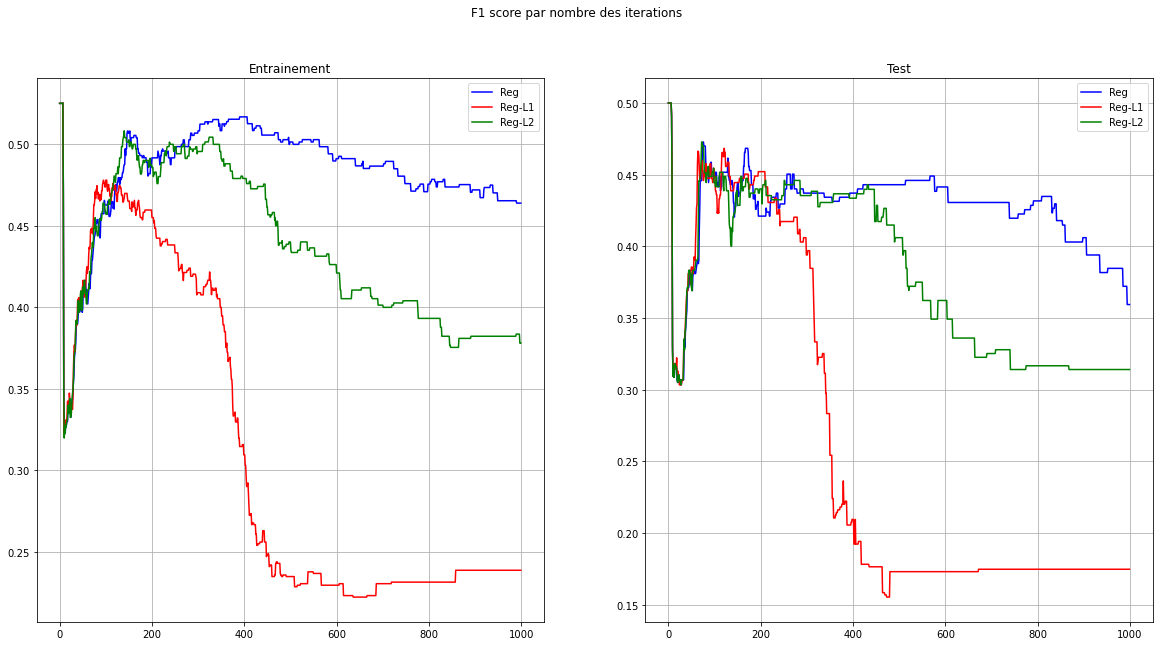

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore", category=ConvergenceWarning)

MAX_IT = 1000
CC = 0.002
COEF_ = np.array([[1.] * X_train.shape[1]])
INTERCEPT_ = np.array([1.])

reglog = LogisticRegression(penalty='none', solver="saga", max_iter=1, warm_start=True, random_state=0)
reglog.coef_ = COEF_
reglog.intercept_ = INTERCEPT_
reglog_l1 = LogisticRegression(penalty='l1', solver="saga", max_iter=1, warm_start=True, random_state=0, C=CC)
reglog_l1.coef_ = COEF_
reglog_l1.intercept_ = INTERCEPT_
reglog_l2 = LogisticRegression(penalty='l2', solver="saga", max_iter=1, warm_start=True, random_state=0, C=CC)
reglog_l2.coef_ = COEF_
reglog_l2.intercept_ = INTERCEPT_

coefs = []
coefs0 =[]
f1train = []
f1test = []

coefs_ridge = []
coefs0_ridge = []
f1train_ridge = []
f1test_ridge = []

coefs_lasso = []
coefs0_lasso = []
f1train_lasso = []
f1test_lasso = []

for it in range(MAX_IT):
    reglog.fit(X_train, Y_train)
    coefs.append(reglog.coef_.flatten().tolist())
    coefs0.append(reglog.intercept_[0])
    f1train.append(f1_score(Y_train, reglog.predict(X_train)))
    f1test.append(f1_score(Y_test, reglog.predict(X_test)))
    
    reglog_l1.fit(X_train, Y_train)
    coefs_lasso.append(reglog_l1.coef_.flatten().tolist())
    coefs0_lasso.append(reglog_l1.intercept_[0])
    f1train_lasso.append(f1_score(Y_train, reglog_l1.predict(X_train)))
    f1test_lasso.append(f1_score(Y_test, reglog_l1.predict(X_test)))
    
    reglog_l2.fit(X_train, Y_train)
    coefs_ridge.append(reglog_l2.coef_.flatten().tolist())
    coefs0_ridge.append(reglog_l2.intercept_[0])
    f1train_ridge.append(f1_score(Y_train, reglog_l2.predict(X_train)))
    f1test_ridge.append(f1_score(Y_test, reglog_l2.predict(X_test)))


coefs = np.array(coefs)
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("F1 score par nombre des iterations")
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(range(MAX_IT), f1train, color="blue", label="Reg")
ax1.plot(range(MAX_IT), f1train_lasso, color="red", label="Reg-L1")
ax1.plot(range(MAX_IT), f1train_ridge, color="green", label="Reg-L2")
ax1.legend()
ax1.set_title("Entrainement")
ax1.grid()

ax2.plot(range(MAX_IT), f1test, color="blue", label="Reg")
ax2.plot(range(MAX_IT), f1test_lasso, color="red", label="Reg-L1")
ax2.plot(range(MAX_IT), f1test_ridge, color="green", label="Reg-L2")
ax2.legend()
ax2.set_title("Test")
ax2.grid()

plt.show()

#### II.1.2. Convergence des paramètres par itérations

Ici, nous avons afficher les valeurs des paramètres thétas pour chaque itération. 

**Analyser les résultats**

- Que remarquez-vous ?
- Analyser la convergence des valeurs des paramètres entre les trois modèles (pourquoi dans les deux modèles avec régularisation, les valeurs se rapprochent plus de 0, pourquoi il y a des paramètres qui convergent plus rappidement que d'autres)
- Est-ce qu'on peut retirer quelques attributs jugés importants par le modèle ? Si oui, lequels ici ? Si non, pourquoi ?
- Est-ce qu'on peut utiliser la régularisation comme sélection d'attribut ? Préciser (avec argumentation)

**Réponse**

- On remarque que les paramétres thetas (sauf theta0 qui n'est pas concérné par la régularisation) finissent tous par tendre vers zeros apres un certains nombre d'itération pour les régularisations L1 et L2. Par ailleurs on remarque qu'ils tendent plus rapidement vers zeros pour L1 plutot que pour L2, de plus pour la régularisation L1 on remarque qu'apres un certains nombre d'itération les paramétres thétas (sauf théta0) sont mis a zeros contrairement a la régularisation L2 ou les paramétres sont juste trés proches de zeros (sauf théta0). Dans le cas de la régression sans régularisation on remarque que certains thetas tendent vers zeros tandis que d'autres non.
- Les valeurs des thetas se rapprochent de zeros pour les deux modeles de régularisation car les deux fonctions de régularisation font en sorte de minimiser le poids des thétas a chaque itération et quand le nombre d'itération devient grand les valeurs des thétas tendent vers zeros pour L2 et sont egales a zeros pour L1. On remarque que des paramétres convergent plus rapidement que d'autres car ceci sont associés a des caractéristiques avec de grandes valeurs (Insuline et glucose) et par elles sont plus pénalisées que les autres thétas associés a des caractéristiques avec des petites valeurs (DiabetesPedigreeFunction).
- On peut retirer certains attributs jugés importants par le modèle lorsque la variance obtenues pour cette caractéristique est petite (lorsque les valeurs prises par cette caractéristique sont uniformément distribuées sur l'intervalle de toutes les valeurs prises) car ce n'est pas une caractéristique qui nous pemettra de séparer les individus, dans notre cas on peut retirer bloodpressure dont les valeurs ne possédent pas de grande variation. On peut egalement eliminer les attributs qui ont des valeurs outliers (bruits statistiques) comme le skin thikness(les valeurs 0 qui sont des valeurs abérantes).
- Oui on peut utiliser la régularisation L1 comme séléction d'attribut car elle permet de forcer les paramétres thétas a prendre des petites valeurs et certains d'entre eux sont meme forcés a zeros aprés convergence et ne rentre donc plus en compte dans l'estimation du modéle contrairement a L2 qui ne permet pas de forcer des paramétres a zéros donc elle ne peut pas etre utilisée pour faire de la séléction d'attributs.

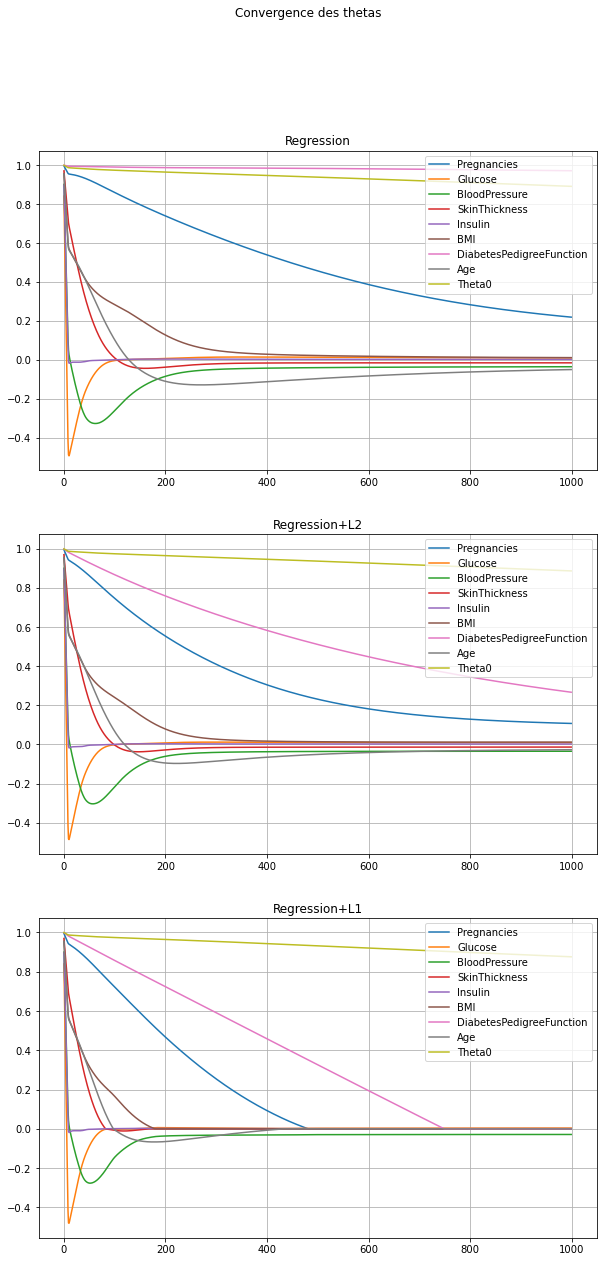

In [12]:
labels = list(diabetes.columns)
labels.pop()
#labels = ["Theta0"] + labels
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.suptitle("Convergence des thetas")
fig.set_figwidth(10)
fig.set_figheight(20)
for i in range(len(labels)): 
    ax1.plot(range(MAX_IT), coefs[:, i], label=labels[i])
    ax3.plot(range(MAX_IT), coefs_lasso[:, i], label=labels[i])
    ax2.plot(range(MAX_IT), coefs_ridge[:, i], label=labels[i])
ax1.plot(range(MAX_IT), coefs0, label="Theta0")
ax2.plot(range(MAX_IT), coefs0_ridge, label="Theta0")
ax3.plot(range(MAX_IT), coefs0_lasso, label="Theta0")
ax1.legend()
ax1.set_title("Regression")
ax1.grid()
ax3.legend()
ax3.set_title("Regression+L1")
ax3.grid()
ax2.legend()
ax2.set_title("Regression+L2")
ax2.grid()

plt.show()

### II.2. Sélection d'attributs

Ici, on va utiliser le même dataset précédent sur plusieurs types de sélection d'attributs.

#### II.2.1. Sélection d'attributs par filtrage (Choix ANOVA)

Nous avons extrait les F values ANOVA pour les différents attributs. 

**Analyser les résultats** 

- Quels sont les attributs les plus importants d'après F values ?
- Pourquoi un attribut est considéré comme important dans ANOVA (aspect mathématique et logique : les valeurs de la'ttribut et de la prédiction Y) ?

**Réponse**
- Les attributs les plus importants d'après F values sont le glucose et BMI car ils ont une plus grande valeur de F value. 
- Un attribut possédant une grande F value est considéré comme important car la F value est le ratio de la variance inter classes / variance intra classes donc plus la F value est grande plus la variance intra classe est petite (les individus de cette classe cad la prédiction Y se ressemblent dans les valeurs prises pour cet attribut) et plus la variance inter classes est grande (les individus de classes différentes cad avec des prédictions de Y différentes ont des valeurs différentes pour cet attribut) donc les attributs possédant une grande F value permettent de bien séparer les classes.

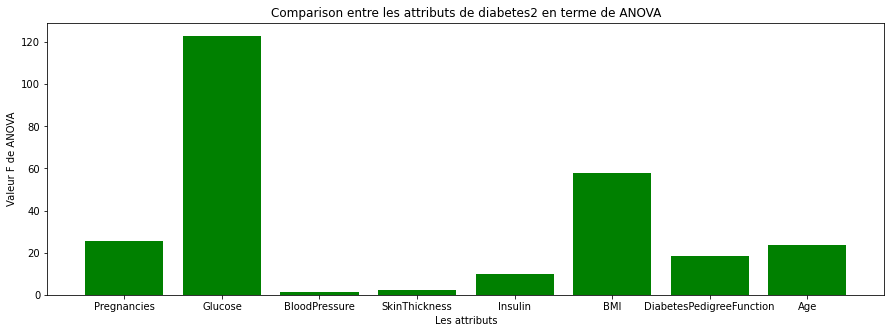

In [13]:
from sklearn.feature_selection import f_classif
f, a = f_classif(X_train, Y_train)

labels_diabetes = list(diabetes.columns[:-1])
x_pos = range(len(f))
plt.figure(figsize=(15,5))
plt.bar(labels_diabetes, f, color="green")
plt.xlabel("Les attributs")
plt.ylabel("Valeur F de ANOVA")
plt.title("Comparison entre les attributs de diabetes2 en terme de ANOVA")

plt.xticks(x_pos, labels_diabetes)

plt.show()


#### II.2.2. Sélection d'attributs par filtrage (Convergence et performance)

Ici, on va utiliser ANOVA pour pré-sélectionner les caractéristiques qui donnent 50% de variance. On veut comparer la convergence du modèle normal contre celui avec pré-sélection ANOVA.

**Analyser les résultats** 

- Pourquoi la performance de la régression sans filtrage est meilleure dans l'entrainement et pas dans et test; et l'inverse pour la régression avec filtrage ? (P.S. on ne parle pas ici du sur-apprentissage; mais des attributs : nombre et qualité)
- Est-ce que le filtrage PEUT prévenir le sur-apprentissage ? Si oui, comment ? Si non, pourquoi ?

**Réponse**

- La performance de la regression sans filtrage est meilleur dans l'entrainement car on prend en considération tous les attributs de tous les individus pour construire le modéle par conséquent le taux d'erreur sur les données d'entrainement est petit or sur les données de test vu qu'on avait prit en considération les attributs non significatif (avec une petite F value, de mauvaises qualités) lors du développement du modele (a l'entrainement) alors le modéle obtenue n'a pas bien généraliser sur les données de test par contre pour le modele avec pré-selection ANOVA on a sélectionner les attributs les plus significatifs (avec une grande F value qui explique mieux Y, de meilleurs qualité) lors du développement du modele par conséquent le modele a pu bien généraliser et a donner de bon résultat sur les données de test mais le fait de réduire le nombre d'attribut sur les quels on construit notre modele fait qu'on obtient de moins bon résultat sur les données d'entrainement.
- Oui il peut prévenir le sur-apprentissage en ne prenant pas en compte tous les attributs lors de l'entrainement (construction du modele) ce qui permet d'eviter de trop bien apprendre les données d'entrainement et d'essayer de trop bien les ajuster ça permet ainsi d'avoir un modele qui généralise mieux sur les données de test (de meilleurs résultats).


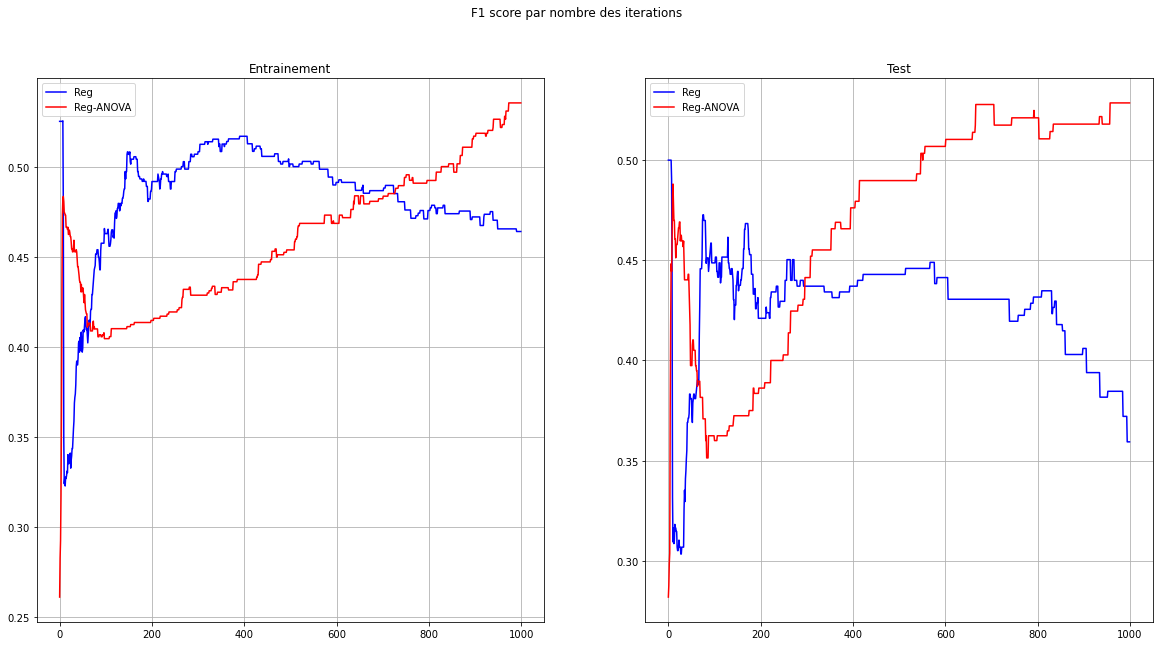

In [14]:
from sklearn.feature_selection import SelectPercentile

selecteur = SelectPercentile(score_func=f_classif, percentile=50)
X_train_new = selecteur.fit_transform(X_train, Y_train)
X_test_new = selecteur.transform(X_test)

reglog_anova = LogisticRegression(penalty='none', solver="saga", max_iter=1, warm_start=True, random_state=0)
reglog_anova.coef_ = np.array([[1.] * X_train_new.shape[1]])
reglog_anova.intercept_ = INTERCEPT_

coefs_anova = []
coefs0_anova =[]
f1train_anova = []
f1test_anova = []

for it in range(MAX_IT):
    reglog_anova.fit(X_train_new, Y_train)
    coefs_anova.append(reglog_anova.coef_.flatten().tolist())
    coefs0_anova.append(reglog_anova.intercept_[0])
    f1train_anova.append(f1_score(Y_train, reglog_anova.predict(X_train_new)))
    f1test_anova.append(f1_score(Y_test, reglog_anova.predict(X_test_new)))

coefs_anova = np.array(coefs_anova)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("F1 score par nombre des iterations")
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(range(MAX_IT), f1train, color="blue", label="Reg")
ax1.plot(range(MAX_IT), f1train_anova, color="red", label="Reg-ANOVA")
ax1.legend()
ax1.set_title("Entrainement")
ax1.grid()

ax2.plot(range(MAX_IT), f1test, color="blue", label="Reg")
ax2.plot(range(MAX_IT), f1test_anova, color="red", label="Reg-ANOVA")
ax2.legend()
ax2.set_title("Test")
ax2.grid()

plt.show()

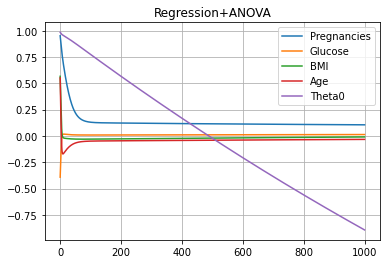

In [15]:
labels_new = selecteur.transform(np.array(diabetes.columns[:-1]).reshape(1, len(diabetes.columns)-1)).flatten()

for i in range(len(labels_new)): 
    plt.plot(range(MAX_IT), coefs_anova[:, i], label=labels_new[i]) # <==============
plt.plot(range(MAX_IT), coefs0_anova, label="Theta0")
plt.legend()
plt.title("Regression+ANOVA")
plt.grid()
plt.show()

#### II.2.3. Comparaison entre les différentes approches de sélections d'attributs

Ici, on veut comparer des modèles appartenant à des différentes approches de sélection d'attributs : 
- **ANOVA** : c'est une modèle qui utilise la sélection d'attributs par filtrage. Ici, on prend les attributs qui participent de 50% de la variance (4 attributs dans notre cas)
- **L1** : c'est un modèle qui utilise la sélection d'attributs intégrée (embdded)
- **FFS (Forward Features Selection)** : c'est un modèle qui utilise la sélection d'attributs enveloppante (wrapper). Il commence par tester un seul attribut et ajouter d'autres en validant la solution à chaque fois. Ici, nous avons choisi 4 attributs. 
- **BFE (Backward Features Elimination)** : c'est un modèle qui utilise la sélection d'attributs enveloppante (wrapper). Il commence par tester tous les attributs et éliminer d'autres en validant la solution à chaque fois. Ici, nous avons choisi 4 attributs. 

On veut tester les modèles par rapport à celui sans sélection d'attributs en se basant sur les critères suivants :
- **F1 entrainement** : ici on veut répondre à la question "combien un modèle peut-il converger vers sa solution ?"
- **F1 test** : ici on veut répondre à la question "combien un modèle peut-il généraliser ?"
- **Nombre des itérations** : ici on veut répondre à la question "combien faut-il d'itérations pour qu'un modèle converge ?"
- **Temps pré-entrainement** : ici on veut répondre à la question "combien de temps faut-il pour préparer les attributs avant l'entrainement ?"
- **Temps entrainement** : ici on veut répondre à la question "combien de temps faut-il pour l'entrainement ?"

*P.S. L'exécution prend un peu de temps*

**Analyser les résultats** 

- Pourquoi la sélection d'attributs envelopante prend plus de temps d'entrainement portant elle utilise moins d'attributs ? (en se basant sur les résultats)
- Pourquoi la régression avec L1 prend plus de temps d'entrainement que la régression normale portant elle prend moins d'itérations ?
- Pourquoi la sélection d'attributs enveloppante donne des performances mieux que celle par filtrage pourtant cette dernière sélectionne les meilleurs attributs en terme de corrélation ? (dans notre cas, c'est le même nombre d'attributs = 4)
- Si vous avez un dataset avec plusieurs attributs et une quantité énorme d'échantillons, proposer une solution avec moins de temps de pré-entrainement+entrainement et plus de performance (par rapport la solution sans sélection d'attributs) en se basant sur les résultats de cette expérimentation.

**Réponse**

- La selection d'attributs envelopante prend plus de temps d'entrainement meme si elle utilise moins d'attributs car elle necessite un plus grand nombre d'itérations pour converger (5000 itérations) contrairement par exemple a la regression avec ANOVA qui prend le moins de temps car le nombre d'attributs séléctionné apres le pré-entrainement s'eleve a 4 ce qui a permit a l'algorithme de converger plus rapidement (au bout de 187 itérations seulement). De plus les méthodes enveloppantes sont trés couteuses en calcul.
- La regression avec L1 prend plus de temps que la regression normale car elle necessite plus de calcule vu que la fonction objective qu'elle cherche a minimiser est composée de 2 parties (la fonction objective de la regression normale plus la fonction du coût de la régularisation L1). C'est une méthode de selection d'attibut intégrée : la selection d'attribut se fait durant l'entrainement.
- La selection d'attributs enveloppante donne de meilleurs performances que celle par filtrage car celle ci utilise un processus de séléction d'attributs qui etudie la corrélation entre un attribut et la sortie Y ainsi que la corrélation entre deux attributs différents (le processus de cross-validation qui etudie l'apport en précision a l'ajout/elimination de chaque attribut) contrairement aux méthodes par filtrage qui ne prennent en considération la corrélation entre variable mais seulement avec la sortie Y (elles peuvent ne pas prendre en compte un attribut jugé non significatif par les méthodes filtrantes mais jugé significatif par les méthodes enveloppantes car associé à un autre attribut ce dernier peut devenir significatif). Donc le sous enssemble d'attributs qu'on aura obtenue avec une méthode enveloppante nous permettra de développer un meilleur modéle.
- D'aprés les résultats obtenue de cette expérimentation, la solution pour la quelle on pourait opter c'est d'utiliser la regression avec ANOVA car elle nous permet de faire un bon compromis entre temps d'entrainement/pré-entrainemant et performance, on peut egalement donner une meilleure amélioration en combinant la methode de régression avec reg L1 et ANOVA : ANOVA nous permettra d'obtenir un groupe d'attributs maximisant la F value ensuite on appliquera la régression avec régularisation L1 sur ce groupe d'attributs de cette maniére on aura fait une double sélection.

In [16]:
from sklearn.feature_selection import SequentialFeatureSelector
import timeit

CMAX_ITER = 5000
creglog = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)
creglog_l1 = LogisticRegression(penalty='l1', solver="saga", max_iter=CMAX_ITER)
creglog_anova = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)

temps = {}
temps_p = {}

temps_debut = timeit.default_timer()
creglog.fit(X_train, Y_train)
temps["reg"] = timeit.default_timer() - temps_debut


temps_debut = timeit.default_timer()
creglog_l1.fit(X_train, Y_train)
temps["l1"] = timeit.default_timer() - temps_debut

temps_debut = timeit.default_timer()
selecteur_anova = SelectPercentile(score_func=f_classif, percentile=50)
X_train_anova= selecteur.fit_transform(X_train, Y_train)
temps_p["anova"] = timeit.default_timer() - temps_debut
X_test_anova = selecteur.transform(X_test)
temps_debut = timeit.default_timer()
creglog_anova.fit(X_train_anova, Y_train)
temps["anova"] = timeit.default_timer() - temps_debut

creglog_ffs = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)
temps_debut = timeit.default_timer()
selecteur_ffs = SequentialFeatureSelector(creglog_ffs, n_features_to_select=4, direction="forward")
X_train_ffs = selecteur_ffs.fit_transform(X_train, Y_train)
temps_p["ffs"] = timeit.default_timer() - temps_debut
X_test_ffs = selecteur_ffs.transform(X_test)
temps_debut = timeit.default_timer()
creglog_ffs.fit(X_train_ffs, Y_train)
temps["ffs"] = timeit.default_timer() - temps_debut

creglog_bfe = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)
temps_debut = timeit.default_timer()
selecteur_bfe = SequentialFeatureSelector(creglog_bfe, n_features_to_select=4, direction="backward")
X_train_bfe = selecteur_bfe.fit_transform(X_train, Y_train)
temps_p["bfe"] = timeit.default_timer() - temps_debut
X_test_bfe = selecteur_bfe.transform(X_test)
temps_debut = timeit.default_timer()
creglog_bfe.fit(X_train_bfe, Y_train)
temps["bfe"] = timeit.default_timer() - temps_debut


pd.DataFrame({
    "Criteres" : ["F1 Entrainement", "F1 Test", "Nombre des itérations", "temps pré-entrainement", "temps entrainement"],
    "Reg" : [f1_score(Y_train, creglog.predict(X_train)), 
             f1_score(Y_test, creglog.predict(X_test)),
             creglog.n_iter_, 0, temps["reg"]],
    "Reg+L1" : [f1_score(Y_train, creglog_l1.predict(X_train)), 
                f1_score(Y_test, creglog_l1.predict(X_test)), 
                creglog_l1.n_iter_, 0, temps["l1"]],
    "ANOVA+Reg" : [f1_score(Y_train, creglog_anova.predict(X_train_anova)), 
                f1_score(Y_test, creglog_anova.predict(X_test_anova)), 
                creglog_anova.n_iter_, temps_p["anova"], temps["anova"]],
    "FFS" : [f1_score(Y_train, creglog_ffs.predict(X_train_ffs)), 
                f1_score(Y_test, creglog_ffs.predict(X_test_ffs)), 
                creglog_ffs.n_iter_, temps_p["ffs"], temps["ffs"]],
    "BFE" : [f1_score(Y_train, creglog_bfe.predict(X_train_bfe)), 
                f1_score(Y_test, creglog_bfe.predict(X_test_bfe)), 
                creglog_bfe.n_iter_, temps_p["bfe"], temps["bfe"]],
})

,Criteres,Reg,Reg+L1,ANOVA+Reg,FFS,BFE
0,F1 Entrainement,0.465574,0.465574,0.389706,0.567568,0.585526
1,F1 Test,0.380165,0.380165,0.37931,0.564516,0.539683
2,Nombre des itérations,[1407],[1404],[287],[5000],[5000]
3,temps pré-entrainement,0,0,0.001062,14.314565,27.210001
4,temps entrainement,0.12435,0.151102,0.016792,0.312463,0.274858
